<a href="https://colab.research.google.com/github/jatbhoir/EVA-Solutions---CLV/blob/master/EVA_Case_Study_CLV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Maximizing Revenue and Retention: Leveraging CLV Insights

---
#Objective:
The primary goal of this, is to build a model custom tailored to Eva Solutions' Business Model for forcasting Customer Lifetime Value.

Focusing on the following:
1.   Enhancing Customer Retention
2.   Maximizing Revenue from the Existig Customers.

#Import Packages

In [2]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Read Data

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#  Read the CSV file using the unicode_escape encoding
df = pd.read_csv('/content/drive/MyDrive/Classroom/SEM2/AMS TA/eCommerce Year 09-10.csv', encoding='unicode_escape')

In [5]:
# Display DataFrame
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,12/1/2009 7:45,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,12/1/2009 7:45,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,12/1/2009 7:45,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,12/1/2009 7:45,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,12/1/2009 7:45,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,12/9/2010 20:01,2.95,17530.0,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,12/9/2010 20:01,3.75,17530.0,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,12/9/2010 20:01,3.75,17530.0,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,12/9/2010 20:01,3.75,17530.0,United Kingdom


#Data Preprocessing

In [6]:
# Checking Null Variables
df.isna().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

As there are Null Variables in the ECommerce Dataset [CustomerID, Desc.], We need to remove these Observations.

In [27]:
df.dropna(inplace = True) # Droping all NA Observations
df = df[~df['Invoice'].str.contains('C', na = False)]
df = df[df['Quantity'] > 0] # Checking for QTY
df = df[df['Price'] > 0]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']) # Formating 'InvoiceDate' from str to DateTime
df['TotalRevenue'] = df['Quantity'] * df['Price'] # Creating Column with TotalRevenue
df.head() # Display Top 5 values

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalRevenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


# Aggregate Model (Historical Approach)

---


In [29]:
# Data Based on grouping around 'CustomerID' & Aggregating Metrics (data)

MDate = df['InvoiceDate'].max() # Setting the Latest Date as Maximum
# CDate = dt.datetime.now() # Testing 'What will happen if we try todays date'

# Calculating Recency, Frequency, Monetary.
data = df.groupby('Customer ID').aggregate(
    {
        'InvoiceDate': lambda date: (MDate - date.min()).days, # Recency: Diff in days from last purchase
        'Invoice': lambda inv: len(inv), # Frequncy: No. of times recorded purchases
        'TotalRevenue': lambda tr: tr.sum(), # Monetary: Total revenue generated by customer
    }
)

# Changing Column Names
data.columns = ['Age', 'No_Transactions', 'TotalRevenue']

In [9]:
# data.shape[0]
data

,Age,No_Transactions,TotalRevenue
Customer ID,,,
12346.0,360,33,372.86
12347.0,39,71,1323.32
12348.0,73,20,222.16
12349.0,224,102,2671.14
12351.0,10,21,300.93
...,...,...,...
18283.0,293,230,641.77
18284.0,66,28,461.68
18285.0,295,12,427.00


**CLV** = Average Purchase Value * Average Purchase Frequency * Average Customer Lifespan * Gross Margin


In [10]:
# Calculating Average Order Value
data['AverageOrderValue'] = data['TotalRevenue'] / data['No_Transactions']
data.head()

,Age,No_Transactions,TotalRevenue,AverageOrderValue
Customer ID,,,,
12346.0,360,33,372.86,11.298788
12347.0,39,71,1323.32,18.638310
12348.0,73,20,222.16,11.108000
12349.0,224,102,2671.14,26.187647
12351.0,10,21,300.93,14.330000


In [11]:
AverageOrderValue = data['TotalRevenue'].sum() / data['No_Transactions'].sum()
tr, nt = data['TotalRevenue'].sum(), data['No_Transactions'].sum()
print(f'Average Purchase Value: ${round(AverageOrderValue, 2)}, TotalRevenue: ${tr}, Total Transactions: {nt}')

Average Purchase Value: $21.66, TotalRevenue: $8832003.274, Total Transactions: 407664


In [12]:
# Calculate Purchase Frequency
PurchaseFrequency = np.mean(data['No_Transactions'])
# PurchaseFrequency = data['No_Transactions'].sum() / len(data)
print(f'Purchase Frequency: {round(PurchaseFrequency, 2)}, len(data): {len(data)}')

Purchase Frequency: 94.54, len(data): 4312


In [13]:
# Calculate Retention Rate by removing one-time purchases from dataset
RetentionRate = data[data['No_Transactions'] > 1].shape[0]/data.shape[0]  # data[(data['No of Transactions'] > 1)] .shape to convert array/table
print(f'Retention Rate: {round(RetentionRate, 2)}%')

Retention Rate: 0.98%


In [14]:
# Calculate Churn Rate
ChurnRate = (1 - RetentionRate)
print(f'Churn Rate: {round(ChurnRate, 2)}%')

Churn Rate: 0.02%


In [15]:
# Calculate Average Customer Lifespan
AverageCustomerLifespan = 1/ChurnRate
print(f'Average Customer Lifespan: {round(AverageCustomerLifespan, 2)}')

Average Customer Lifespan: 47.38


In [16]:
# Gross Margin
GrossMargin = 0.60 # Change Accordingly [Here took 60%]

In [17]:
# Calculate Customer Lifetime Value
CLV = (AverageOrderValue * GrossMargin * AverageCustomerLifespan) #/ data.shape[0]
print(f'Customer Lifetime Value: ${round(CLV, 2)}')

Customer Lifetime Value: $615.95


In [ ]:
data = data[data['No_Transactions'] > 1]
data['AverageOrderValue'] = round((data['TotalRevenue'] / data['No_Transactions']), 2)
data['CLV'] = round((data['AverageOrderValue'] * GrossMargin * AverageCustomerLifespan), 2)
data.head()

In [19]:
top = data.sort_values(by = 'CLV', ascending = False)
top.head()

,Age,No_Transactions,TotalRevenue,AverageOrderValue,CLV
Customer ID,,,,,
15760.0,265,2,13916.34,6958.17,197826.13
15202.0,55,3,6001.49,2000.50,56875.75
12737.0,133,2,3710.50,1855.25,52746.18
17940.0,371,17,26286.75,1546.28,43961.93
14028.0,185,9,10396.50,1155.17,32842.37


In [20]:
lst = data.sort_values(by = 'CLV', ascending = True)
lst.head()

,Age,No_Transactions,TotalRevenue,AverageOrderValue,CLV
Customer ID,,,,,
17816.0,359,38,75.76,1.99,56.58
15503.0,361,53,120.06,2.27,64.54
17916.0,368,19,43.87,2.31,65.68
15583.0,11,46,107.86,2.34,66.53
14684.0,25,98,232.27,2.37,67.38


In [21]:
df.loc[df['Customer ID'] == 15760.0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalRevenue
129903,501766,M,Manual,1,2010-03-19 11:35:00,6958.17,15760.0,Norway,6958.17
129987,501768,M,Manual,1,2010-03-19 11:45:00,6958.17,15760.0,Norway,6958.17


In [22]:
# Data Based on grouping around 'Country' & Aggregating Metrics (data)

country = df.groupby('Country').aggregate(
    {
'InvoiceDate': lambda date: (MDate - date.min()).days, # Diff in days from last purchase
        'Invoice': lambda inv: len(inv), # No. of times recorded purchases
        'TotalRevenue': lambda tr: tr.sum(), # Total revenue generated by customer
       # 'Quantity': lambda qty: qty.sum(), # No. of items bought by the customer
    }
)

country.columns = ['Age', 'No_Transactions', 'TotalRevenue']
country = country.sort_values(by = 'TotalRevenue', ascending = False)

In [23]:

country['AverageOrderValue'] = round((data['TotalRevenue'] / country['No_Transactions']), 2)
country['CLV'] = round((country ['AverageOrderValue'] * GrossMargin * AverageCustomerLifespan), 2)
country = country.sort_values(by = 'CLV', ascending = False)
country.head()

,Age,No_Transactions,TotalRevenue,AverageOrderValue,CLV
Country,,,,,
United Kingdom,373,370929,7414755.963,NaN,NaN
EIRE,373,8507,356085.210,NaN,NaN
Netherlands,372,2729,268786.000,NaN,NaN
Germany,373,7654,202395.321,NaN,NaN
France,373,5470,146215.420,NaN,NaN


<Axes: xlabel='Country', ylabel='CLV'>

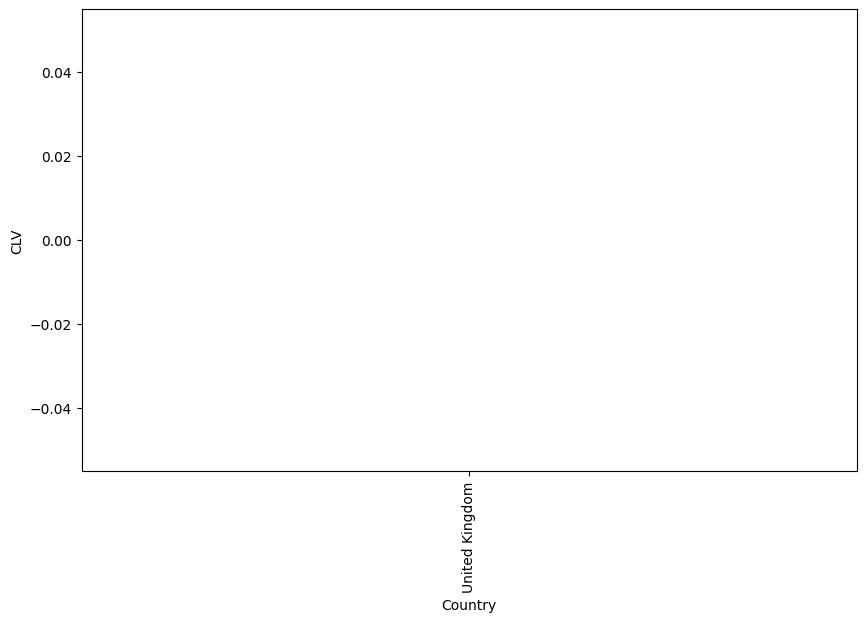

In [24]:
# @title CLV based on Country
fig = plt.figure(figsize = (10,6))
plt.xticks(rotation = 90)
sns.lineplot(data = country['CLV'])

In [25]:
# data.to_excel('/content/drive/MyDrive/output.xlsx', index = True)

In [26]:
# # data Based on grouping around 'CustomerID' & Aggregating Metrics (data)

# MDate = df['InvoiceDate'].max() # Setting the Latest Date as Maximum
# # CDate = dt.datetime.now() # Testing 'What will happen if we try todays date'

# # Calculating Recency, Frequency, Monetary.
# data = df.groupby('CustomerID').aggregate(
#     {
#         'InvoiceDate': lambda date: (MDate - date.min()).days, # Diff in days from last purchase
#         'InvoiceNo': lambda inv: inv.nunique(), # No. of times recorded purchases
#         'TotalRevenue': lambda tr: tr.sum(), # Total revenue generated by customer
#     }
# )


# # Changing Column Names
# data.columns = ['Recency', 'Frequency', 'Monetary']

# data['Monetary'] = data['Monetary'] / data['Frequency']

# data = data[data['Frequency'] > 1]

# data.to_excel('/content/drive/MyDrive/output.xlsx', index = True)